In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/machine learning/seg.zip" -d "/content/drive/MyDrive/machine learning/seg_1"

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from tensorflow.keras.backend import backend as k
from tensorflow.keras.callbacks import History
from tensorflow.keras.applications.vgg16 import VGG16
import seaborn as sns
import cv2
import itertools
import os
import numpy as np
import pandas as pd
import shutil
import random
import glob
import imageio
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
print('Importing Done')

Importing Done


In [ ]:
# moving files from dump folder to train, test and valid
subfolders=['buildings','forest','glacier','mountain','sea','street']
if os.path.isdir(r'train/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    for i in subfolders:
        shutil.move(f'{i}','train') ## moves files fro, source to destination
        os.mkdir(f'valid/{i}')
        valid_samples=random.sample(os.listdir(f'train/{i}'),660)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}',f'valid/{i}')

In [ ]:
#creating datasets for the train, validation 
train_images=[]
train_labels=[]
for directory_path in glob.glob(r'/content/drive/MyDrive/machine learning/seg_1/seg/train/*'):
    label=directory_path.split('\\')[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path,'*.jpg')):
        print(img_path)
        img=cv2.imread(img_path,cv2.IMREAD_COLOR)
        img=cv2.resize(img,(128,128))
        img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
train_images=np.array(train_images)
train_labels=np.array(train_labels)

valid_images=[]
valid_labels=[]
for directory_path in glob.glob('/content/drive/MyDrive/machine learning/seg_1/seg/valid/*'):
    label=directory_path.split('\\')[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path,'*.jpg')):
        print(img_path)
        img=cv2.imread(img_path,cv2.IMREAD_COLOR)
        img=cv2.resize(img,(128,128))
        img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        valid_images.append(img)
        valid_labels.append(label)
valid_images=np.array(valid_images)
valid_labels=np.array(valid_labels)

test_images=[]
test_labels=[]
for directory_path in glob.glob('/content/drive/MyDrive/machine learning/seg_1/seg/test/*'):
    label=directory_path.split('\\')[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path,'*.jpg')):
        print(img_path)
        img=cv2.imread(img_path,cv2.IMREAD_COLOR)
        img=cv2.resize(img,(128,128))
        img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)
test_images=np.array(test_images)
test_labels=np.array(test_labels)

In [ ]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded=le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded=le.transform(train_labels)
le.fit(valid_labels)
valid_labels_encoded=le.transform(valid_labels)

In [ ]:
X_train,y_train,X_test,y_test, X_valid, y_valid=train_images,train_labels_encoded,test_images,test_labels_encoded,valid_images,valid_labels_encoded

In [ ]:
X_train=X_train.astype('float32')
X_valid=X_valid.astype('float32')
X_test=X_test.astype('float32')

X_train=X_train/255
X_valid=X_valid/255
X_test=X_test/255

In [ ]:
print('Shape of train dataset:', X_train.shape)
print('Shape of valid dataset:',X_valid.shape)
print('Shape of test dataset:', X_test.shape)

Shape of train dataset: (10074, 128, 128, 3)
Shape of valid dataset: (3960, 128, 128, 3)
Shape of test dataset: (3000, 128, 128, 3)


In [ ]:
def plt_train_val_acc(x,val_acc,train_acc,colors=['b']):
    plt.figure(figsize=(12,6))
    plt.grid()
    plt.plot(x,val_acc,'b',label="Validation Accuracy")
    plt.plot(x,train_acc,'r',label="Train Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy after each epoch')
    plt.legend()
    
def plt_train_val_loss(x,val_loss,train_loss,colors=['b']):
    plt.figure(figsize=(12,6))
    plt.grid()
    plt.plot(x,val_loss,'b',label="Validation Loss")
    plt.plot(x,train_loss,'r',label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel('Categorical Crossentropy loss')
    plt.legend()

In [ ]:
def plot_confusion_matrix(test_y,predict_y):
    C=confusion_matrix(test_y,predict_y)#Binary Confusion Matrix
    A=(((C.T)/(C.sum(axis=1))).T)#Recall Matrix
    B=(C/C.sum(axis=0))#Precision Matrix
    
    plt.figure(figsize=(20,4))
    labels=[0,1,2,3,4,5]
    
    cmap=sns.light_palette('blue')
    plt.subplot(1,3,1)
    sns.heatmap(C,annot=True,cmap=cmap,fmt='.3f',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Orginal class')
    plt.title('Confusion matrix [0:Buildings, 1:Forest, 2:Glacier, 3: Mountain, 4:sea, 5:Street]')
    
    plt.subplot(1,3,2)
    sns.heatmap(B,annot=True,cmap=cmap,fmt='.3f',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Orginal class')
    plt.title('Precision matrix [0:Buildings, 1:Forest, 2:Glacier, 3: Mountain, 4:sea, 5:Street]')
    
    plt.subplot(1,3,3)
    sns.heatmap(A,annot=True,cmap=cmap,fmt='.3f',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Orginal class')
    plt.title('Recall matrix [0:Buildings, 1:Forest, 2:Glacier, 3: Mountain, 4:sea, 5:Street]')
    
    plt.show()

In [ ]:
img_width, img_height=128,128

train_data_dir=r' C:\Users\vamsi\Desktop\Tensor flow\seg\train'
validation_data_dir=r'C:\Users\vamsi\Desktop\Tensor flow\seg\valid'
nb_train_samples=10074
nb_validation_samples=3960
epochs=300
batch_size=32

if tf.keras.backend.image_data_format()=='channels_first':
    intput_shape=(3,img_width, img_height)
else:
    intput_shape=(img_width, img_height,3)

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                shear_range=0.2,
                                rotation_range=20,
                                width_shift_range=0.2)
                                
train_generator=train_datagen.flow_from_directory(r'/content/drive/MyDrive/machine learning/seg_1/seg/train',
                                                  target_size=(128,128),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')
val_datagen=ImageDataGenerator(rescale=1./255)
validation_generator=val_datagen.flow_from_directory(r'/content/drive/MyDrive/machine learning/seg_1/seg/valid',
                                                  target_size=(128,128),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(r'/content/drive/MyDrive/machine learning/seg_1/seg/test',
                                                  target_size=(128,128),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')




Found 10074 images belonging to 6 classes.
Found 3960 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
vgg = VGG16(input_shape=(128,128,3), weights='imagenet', include_top=False)
#here [3] denotes for RGB images(3 channels)

#don't train existing weights
for layer in vgg.layers:
    layer.trainable = False
model=Sequential()
model.add(vgg)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=0.0001),
                    metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8192)              32768     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

In [ ]:
his=History()

save = tf.keras.callbacks.ModelCheckpoint(r'/content/drive/MyDrive/machine learning/seg_1/seg/model/VGG16.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='min')
    
history = model.fit(x=train_generator,
            steps_per_epoch=nb_train_samples//batch_size,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples//batch_size,
            callbacks=[his,save],
            epochs=100,
            verbose=2)

Epoch 1/100
314/314 - 60s - loss: 1.4015 - accuracy: 0.4546 - val_loss: 0.7384 - val_accuracy: 0.7660

Epoch 00001: val_loss improved from inf to 0.73837, saving model to /content/drive/MyDrive/machine learning/seg_1/seg/model/VGG16.01-0.74.hdf5
Epoch 2/100
314/314 - 59s - loss: 1.1448 - accuracy: 0.5614 - val_loss: 0.6056 - val_accuracy: 0.8051

Epoch 00002: val_loss improved from 0.73837 to 0.60560, saving model to /content/drive/MyDrive/machine learning/seg_1/seg/model/VGG16.02-0.61.hdf5
Epoch 3/100
314/314 - 59s - loss: 1.0098 - accuracy: 0.6114 - val_loss: 0.5409 - val_accuracy: 0.8224

Epoch 00003: val_loss improved from 0.60560 to 0.54093, saving model to /content/drive/MyDrive/machine learning/seg_1/seg/model/VGG16.03-0.54.hdf5
Epoch 4/100
314/314 - 60s - loss: 0.9097 - accuracy: 0.6603 - val_loss: 0.4885 - val_accuracy: 0.8412

Epoch 00004: val_loss improved from 0.54093 to 0.48849, saving model to /content/drive/MyDrive/machine learning/seg_1/seg/model/VGG16.04-0.49.hdf5
Epoc

In [ ]:
if os.path.isfile(r'/content/drive/MyDrive/machine learning/seg_1/seg/model/VGG16/VGG16_cnn_model.h5') is False:
    model.save(r'/content/drive/MyDrive/machine learning/seg_1/seg/model/VGG16/VGG16_cnn_model.h5')

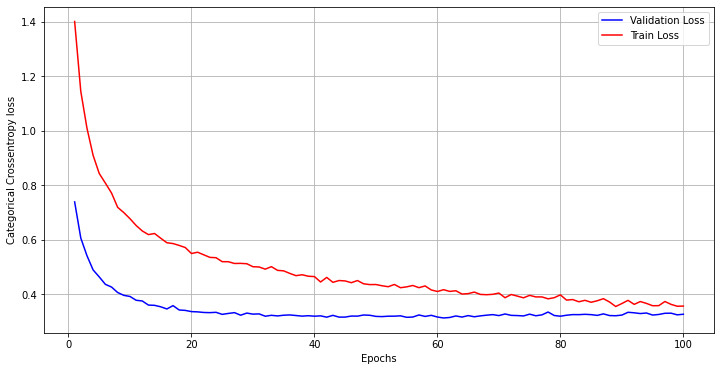

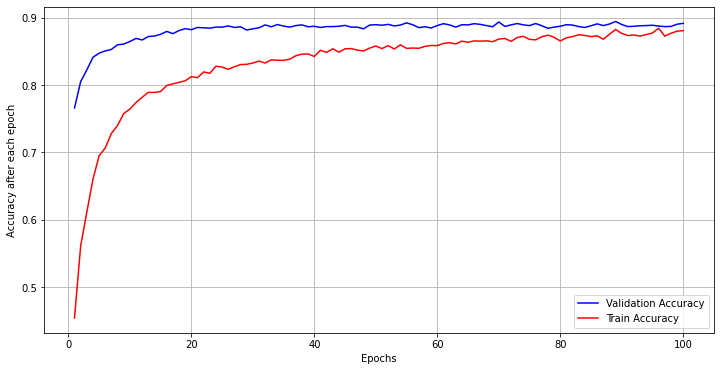

In [ ]:
epochs=100
history=model.history

x=list(range(1,epochs+1))
val_loss=history.history['val_loss']
train_loss=history.history['loss']
plt_train_val_loss(x,val_loss,train_loss)

val_acc=history.history['val_accuracy']
train_acc=history.history['accuracy']
plt_train_val_acc(x,val_acc,train_acc)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


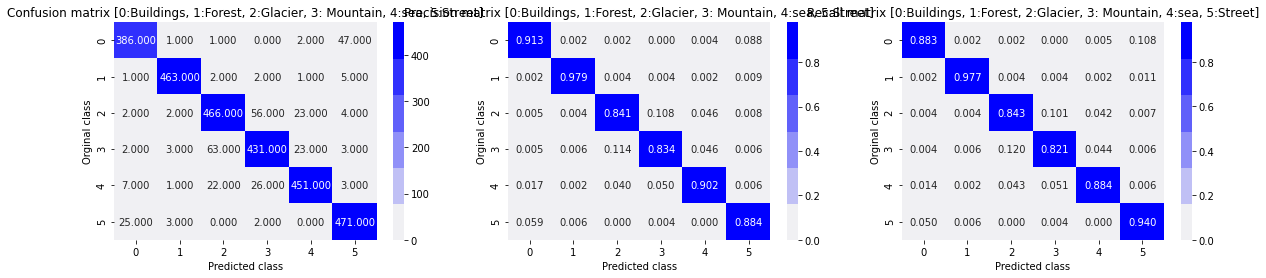

classification report on test(unseen) data

              precision    recall  f1-score   support

           0       0.91      0.88      0.90       437
           1       0.98      0.98      0.98       474
           2       0.84      0.84      0.84       553
           3       0.83      0.82      0.83       525
           4       0.90      0.88      0.89       510
           5       0.88      0.94      0.91       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000

Test accuracy on unseen data: 



0.8893333333333333

In [ ]:
# Model predection
model=load_model(r'/content/drive/MyDrive/machine learning/seg_1/seg/model/VGG16/VGG16_cnn_model.h5')

y_pred=model.predict_classes(X_test,verbose=0)

# plotting Confusion matrix, Precision and Recall

plot_confusion_matrix(test_labels_encoded,y_pred) # confusion matrix

print('classification report on test(unseen) data\n')  # Precision
print(classification_report(test_labels_encoded,y_pred))

print('Test accuracy on unseen data: \n') # Recall
accuracy_score(test_labels_encoded, y_pred)

In [ ]:
from tensorflow.keras.applications import ResNet50

ResNet_model=ResNet50(include_top=False, weights= 'imagenet',  input_shape=(128,128,3))

for layer in ResNet_model.layers[:143]:
    layer.trainable = False

for i, layer in enumerate(ResNet_model.layers):
    print(i, layer.name, "-", layer.trainable)

model_1 = Sequential()
model_1.add(ResNet_model)
model_1.add(Flatten())
model_1.add(BatchNormalization())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(BatchNormalization())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(BatchNormalization())
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(BatchNormalization())
model_1.add(Dense(6, activation='softmax'))
 
model_1.compile(optimizer =Adam(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
model_1.summary()

In [ ]:
his=History()
my_callbacks = tf.keras.callbacks.ModelCheckpoint(r'/content/drive/MyDrive/machine learning/seg_1/seg/model_ResNet/ResNet50.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_loss',verbose=0,save_best_only=True,save_weights_only=False, mode='auto')
    
history1 = model_1.fit(x=train_generator,
            steps_per_epoch=nb_train_samples//batch_size,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples//batch_size,
            callbacks=[his,my_callbacks],
            epochs=100,
            verbose=2)

Epoch 1/100
314/314 - 59s - loss: 1.0398 - accuracy: 0.6164 - val_loss: 1.7379 - val_accuracy: 0.3798
Epoch 2/100
314/314 - 60s - loss: 1.0294 - accuracy: 0.6159 - val_loss: 0.9915 - val_accuracy: 0.6176
Epoch 3/100
314/314 - 60s - loss: 1.0226 - accuracy: 0.6250 - val_loss: 0.9311 - val_accuracy: 0.6270
Epoch 4/100
314/314 - 60s - loss: 1.0169 - accuracy: 0.6288 - val_loss: 1.3758 - val_accuracy: 0.5513
Epoch 5/100
314/314 - 59s - loss: 1.0077 - accuracy: 0.6354 - val_loss: 1.6754 - val_accuracy: 0.4629
Epoch 6/100
314/314 - 59s - loss: 0.9906 - accuracy: 0.6399 - val_loss: 1.3162 - val_accuracy: 0.5252
Epoch 7/100
314/314 - 59s - loss: 0.9881 - accuracy: 0.6456 - val_loss: 2.3842 - val_accuracy: 0.3808
Epoch 8/100
314/314 - 59s - loss: 0.9798 - accuracy: 0.6454 - val_loss: 1.2230 - val_accuracy: 0.5185
Epoch 9/100
314/314 - 59s - loss: 0.9742 - accuracy: 0.6454 - val_loss: 1.4233 - val_accuracy: 0.5348
Epoch 10/100
314/314 - 59s - loss: 0.9718 - accuracy: 0.6503 - val_loss: 1.5464 - 

In [ ]:
if os.path.isfile(r'/content/drive/MyDrive/machine learning/seg_1/seg/model_ResNet/ResNet_cnn_model.h5') is False:
    model.save(r'/content/drive/MyDrive/machine learning/seg_1/seg/model_ResNet/ResNet_cnn_model.h5')

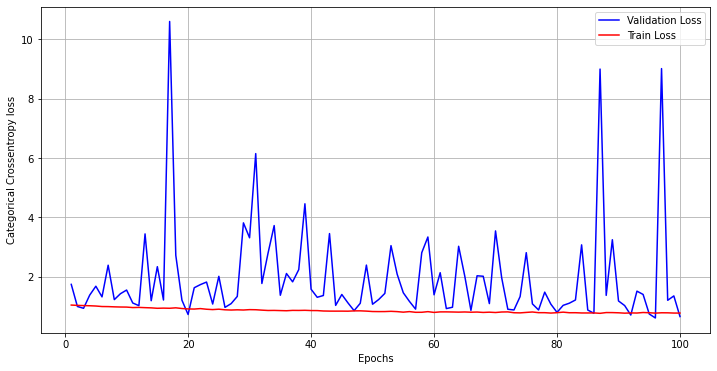

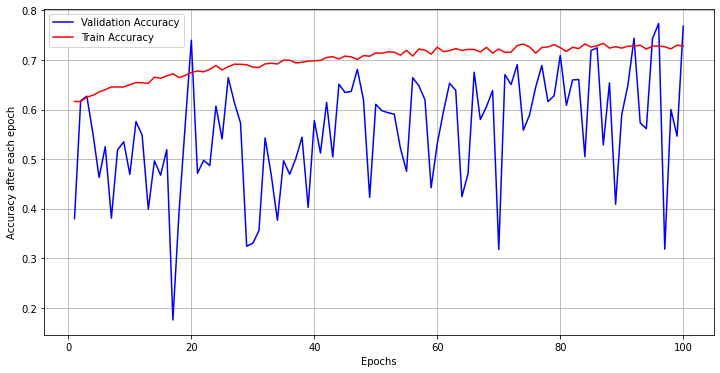

In [ ]:
history=model_1.history

epochs=100
x=list(range(1,epochs+1))
val_loss=history1.history['val_loss']
train_loss=history1.history['loss']
plt_train_val_loss(x,val_loss,train_loss)

val_acc=history1.history['val_accuracy']
train_acc=history1.history['accuracy']
plt_train_val_acc(x,val_acc,train_acc)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


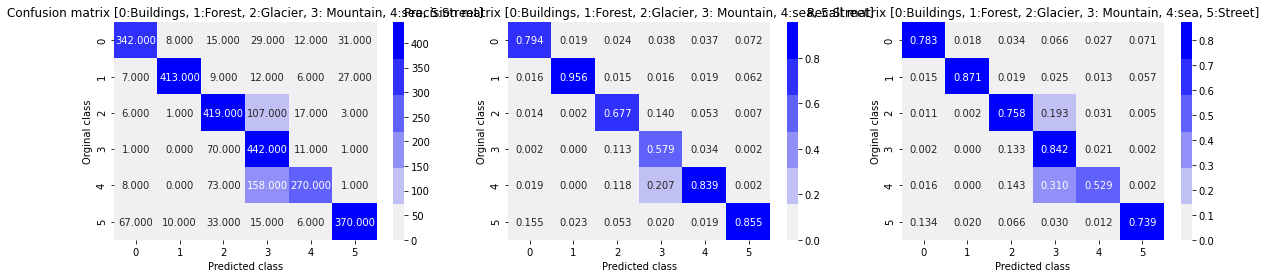

classification report on test(unseen) data

              precision    recall  f1-score   support

           0       0.79      0.78      0.79       437
           1       0.96      0.87      0.91       474
           2       0.68      0.76      0.72       553
           3       0.58      0.84      0.69       525
           4       0.84      0.53      0.65       510
           5       0.85      0.74      0.79       501

    accuracy                           0.75      3000
   macro avg       0.78      0.75      0.76      3000
weighted avg       0.78      0.75      0.75      3000

Test accuracy on unseen data: 



0.752

In [ ]:
# Model predection
model=load_model(r'/content/drive/MyDrive/machine learning/seg_1/seg/model_ResNet/ResNet_cnn_model.h5')

y_pred=model_1.predict_classes(X_test,verbose=0)

# plotting Confusion matrix, Precision and Recall

plot_confusion_matrix(test_labels_encoded,y_pred) # confusion matrix

print('classification report on test(unseen) data\n')  # Precision
print(classification_report(test_labels_encoded,y_pred))

print('Test accuracy on unseen data: \n') # Recall
accuracy_score(test_labels_encoded, y_pred)